In [1]:
%pip show onnx
# use onnx < 1.15

Name: onnx
Version: 1.14.1
Summary: Open Neural Network Exchange
Home-page: https://github.com/onnx/onnx
Author: ONNX
Author-email: onnx-technical-discuss@lists.lfaidata.foundation
License: Apache License v2.0
Location: c:\users\mahesa lizardy\appdata\local\programs\python\python310\lib\site-packages
Requires: numpy, protobuf, typing-extensions
Required-by: tf2onnx
Note: you may need to restart the kernel to use updated packages.


In [17]:
%pip install onnx==1.14.1 

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 581.0 kB/s eta 0:00:23
    --------------------------------------- 0.2/13.3 MB 871.5 kB/s eta 0:00:16
    --------------------------------------- 0.3/13.3 MB 1.3 MB/s eta 0:00:11
   - -------------------------------------- 0.5/13.3 MB 1.7 MB/s eta 0:00:08
   - -------------------------------------- 0.6/13.3 MB 1.9 MB/s eta 0:00:07
   - -------------------------------------- 0.6/13.3 MB 1.8 MB/s eta 0:00:07
   -- ------------------------------------- 0.7/13.3 MB 1.7 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/13.3 MB 1.8 MB/s eta 0:00:07
   -- ------------------------------------- 1.0/13.3 MB 1.8 MB/s eta 0:00:07
   --- ------------------------------------ 1.1/13.3 MB 2.0 MB/s eta 0:00:07
   --- ---------

  You can safely remove it manually.


In [20]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

import os
import tarfile
import pandas as pd
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from mltu.preprocessors import WavReader

from mltu.tensorflow.dataProvider import DataProvider
from mltu.transformers import LabelIndexer, LabelPadding, SpectrogramPadding
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

from model import train_model
from configs import ModelConfigs

In [21]:
import torch
torch.cuda.is_available()

True

In [22]:
dataset_path = "./dataset/"
metadata_path = "../dataset/metadata.csv"
wavs_path = dataset_path + "/Audio/"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep=",", header=None)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]

In [7]:
metadata_df

file_name                           normalized_transcription
0   Female_1/1                          besok pada free semua kan
1   Female_1/2  Setelah kita dinner rencananya akan ada after-...
2   Female_1/3      Eh liat deh boneka teddy bear nya cute banget
3   Female_1/4  No kamu keluar dari voyage dome belok kiri lur...
4   Female_1/5              Sebenernya dia tipikal cowok red flag
..         ...                                                ...
70   Male_1/21         Anyway kita enaknya pergi ke cafe mana ya?
71   Male_1/22                       Aku mau pesen cheesecake deh
72   Male_1/23  Sebelum pergi dari sini, kita post foto-foto k...
73   Male_1/24                    Thank you udah bayarin bis tadi
74   Male_1/25         Kapan-kapan kita ke water boom di sana yuk

[75 rows x 2 columns]

In [10]:
dataset = [[f"../dataset/korpus/Audio/{file}.wav", label.lower()] for file, label in metadata_df.values.tolist()]

In [11]:
dataset

[['../dataset/korpus/Audio/Female_1/1.wav', 'besok pada free semua kan'],
 ['../dataset/korpus/Audio/Female_1/2.wav',
  'setelah kita dinner rencananya akan ada after-party'],
 ['../dataset/korpus/Audio/Female_1/3.wav',
  'eh liat deh boneka teddy bear nya cute banget'],
 ['../dataset/korpus/Audio/Female_1/4.wav',
  'no kamu keluar dari voyage dome belok kiri lurus terus nanti ketemu food junction'],
 ['../dataset/korpus/Audio/Female_1/5.wav',
  'sebenernya dia tipikal cowok red flag'],
 ['../dataset/korpus/Audio/Female_1/6.wav',
  'wah glaze di cakenya enak banget'],
 ['../dataset/korpus/Audio/Female_1/7.wav', 'next year mau ke europe?'],
 ['../dataset/korpus/Audio/Female_1/8.wav',
  'menurut aku, ini tempat makan paling hidden gem'],
 ['../dataset/korpus/Audio/Female_1/9.wav', 'kamu takut naik roller-coaster?'],
 ['../dataset/korpus/Audio/Female_1/10.wav',
  'semua makanan di sini buy one get one'],
 ['../dataset/korpus/Audio/Female_1/11.wav',
  'itinerary penting dibuat loh sebelum 

In [12]:

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

In [14]:
max_text_length, max_spectrogram_length = 0, 0
for file_path, label in tqdm(dataset):
    spectrogram = WavReader.get_spectrogram(file_path, frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length)
    valid_label = [c for c in label if c in configs.vocab]
    max_text_length = max(max_text_length, len(valid_label))
    max_spectrogram_length = max(max_spectrogram_length, spectrogram.shape[0])
    configs.input_shape = [max_spectrogram_length, spectrogram.shape[1]]

configs.max_spectrogram_length = max_spectrogram_length
configs.max_text_length = max_text_length
configs.save()

100%|██████████| 75/75 [00:01<00:00, 47.52it/s]


In [15]:
print(max_text_length, max_spectrogram_length )

81 1024


In [16]:
# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[
        WavReader(frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length),
        ],
    transformers=[
        SpectrogramPadding(max_spectrogram_length=configs.max_spectrogram_length, padding_value=0),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

In [17]:

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.8)


In [18]:

# Creating TensorFlow model architecture
model = train_model(
    input_dim = configs.input_shape,
    output_dim = len(configs.vocab),
    dropout=0.5
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate), 
    loss=CTCloss(), 
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
        ],
    run_eagerly=False
)
model.summary(line_length=300)

Model: "model"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                                                          Output Shape                                                                                                            Param #                                      
 input (InputLayer)                                                                                                                    [(None, 1024, 193)]                                                                                                     0                                            
                                                                                  

In [19]:

# Define callbacks
earlystopper = EarlyStopping(monitor="val_CER", patience=20, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.8, min_delta=1e-10, patience=5, verbose=1, mode="auto")
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)

# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, "train.csv"))
val_data_provider.to_csv(os.path.join(configs.model_path, "val.csv"))


Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 485.4405 - CER: 2.1852 - WER: 1.0264
Epoch 1: val_CER improved from inf to 1.00000, saving model to Models/05_sound_to_text\202312021837\model.h5
8/8 [==============================] - 67s 7s/step - loss: 485.4405 - CER: 2.1852 - WER: 1.0264 - val_loss: 180.5589 - val_CER: 1.0000 - val_WER: 0.9917 - lr: 5.0000e-04
Epoch 2/10


c:\Users\mahesa lizardy\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 192.9907 - CER: 1.0000 - WER: 0.9935
Epoch 2: val_CER did not improve from 1.00000
8/8 [==============================] - 69s 9s/step - loss: 192.9907 - CER: 1.0000 - WER: 0.9935 - val_loss: 177.3073 - val_CER: 1.0000 - val_WER: 0.9917 - lr: 5.0000e-04
Epoch 3/10
1/8 [==>...........................] - ETA: 57s - loss: 150.4374 - CER: 1.0000 - WER: 0.9896

KeyboardInterrupt: 

In [2]:
import numpy as np

In [17]:
import typing
import numpy as np

from mltu.inferenceModel import OnnxInferenceModel
from mltu.preprocessors import WavReader
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer

class WavToTextModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, data: np.ndarray):
        data_pred = np.expand_dims(data, axis=0)

        preds = self.model.run(None, {self.input_name: data_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text


  0%|          | 0/15 [00:00<?, ?it/s]

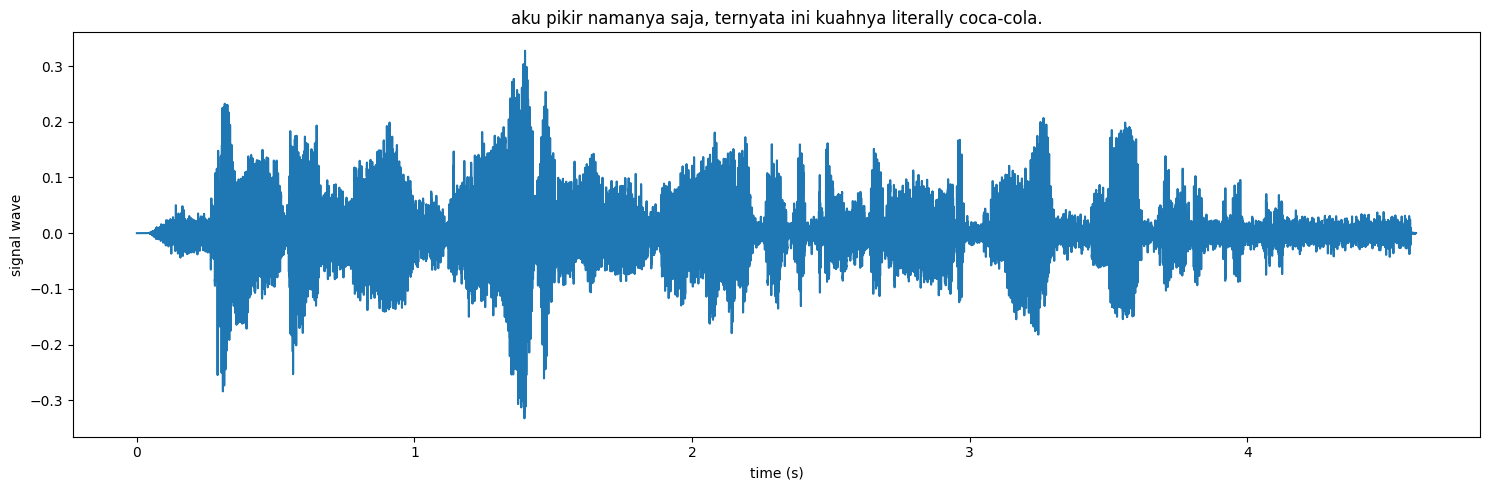

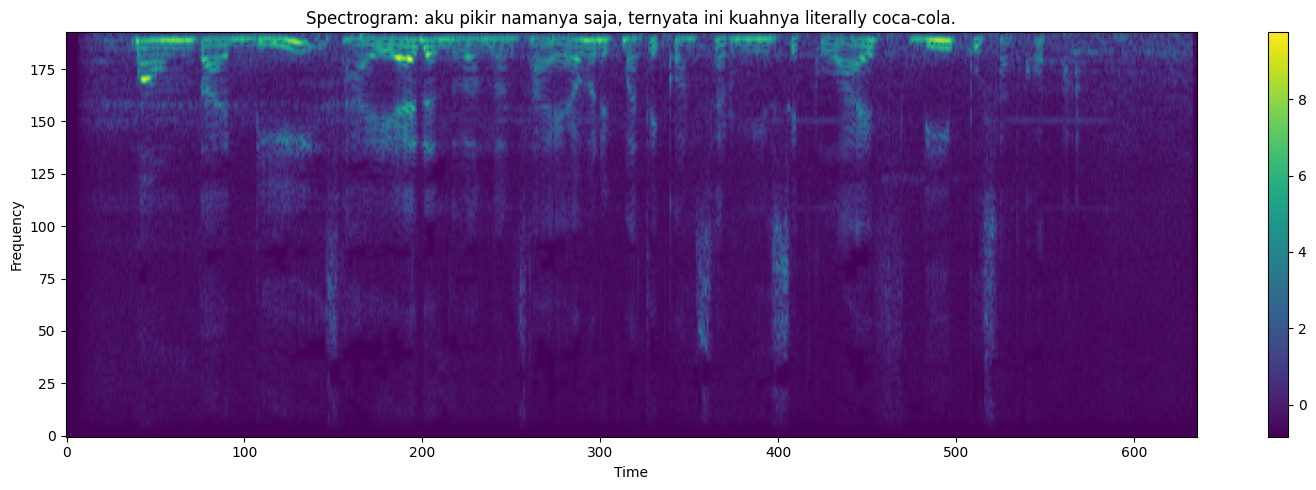

  7%|▋         | 1/15 [00:00<00:13,  1.00it/s]

3
aku pikir namanya saja ternyata ini kuahnya literally cocacola


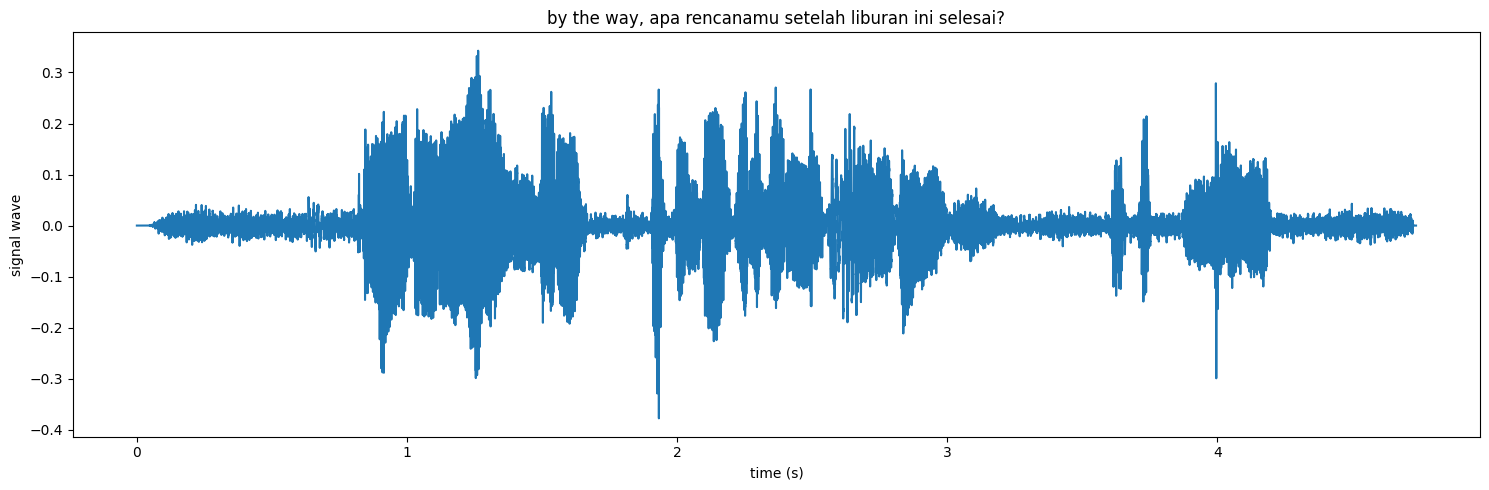

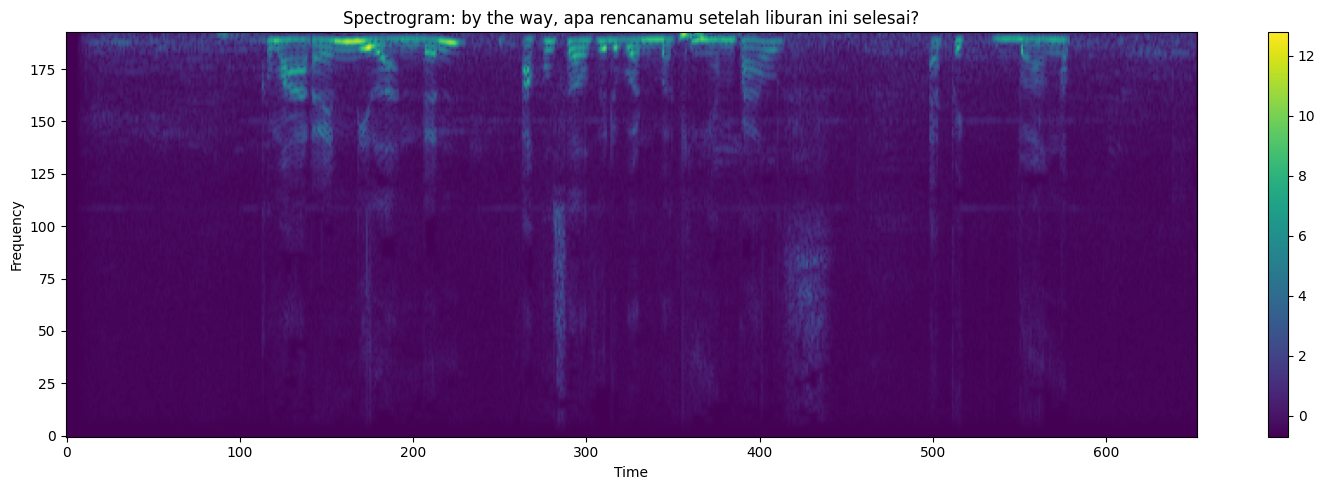

 13%|█▎        | 2/15 [00:01<00:11,  1.14it/s]

2
by the way apa rencanamu setelah liburan ini selesai?


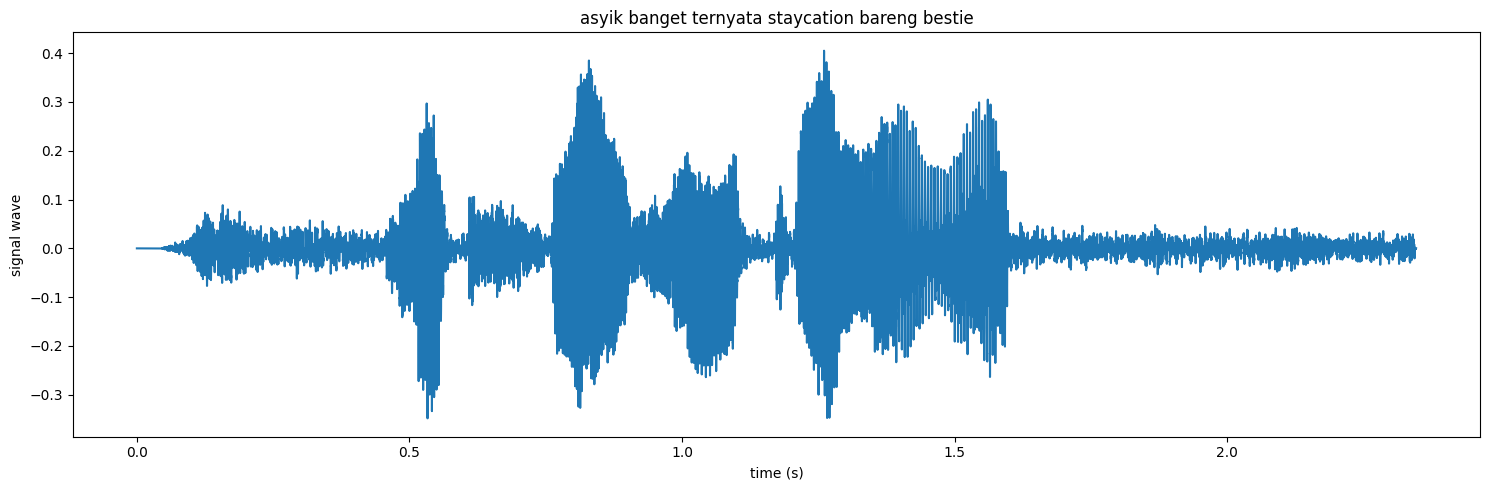

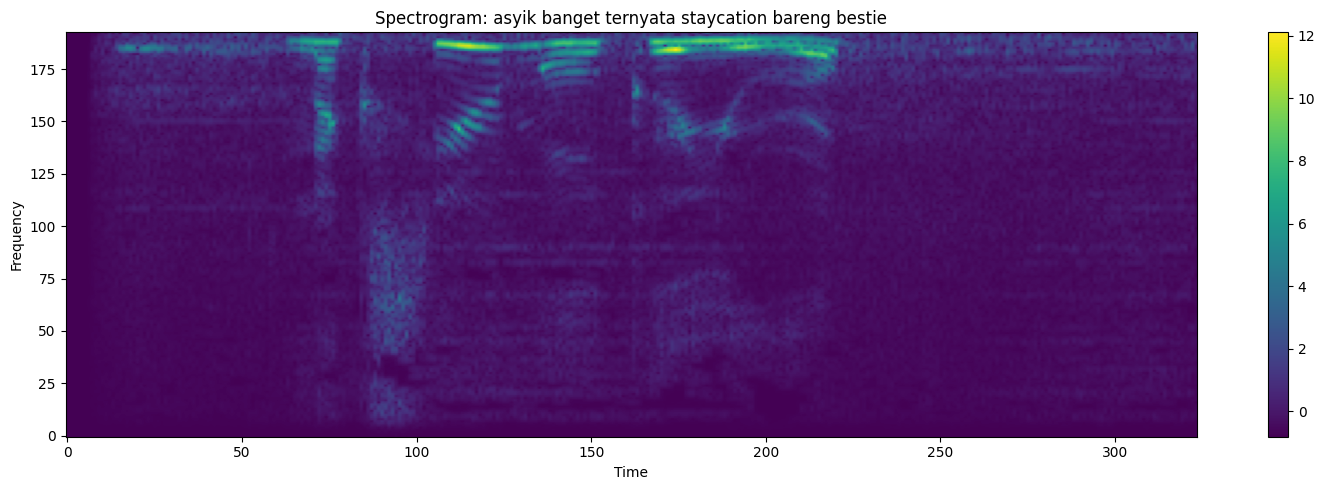

 20%|██        | 3/15 [00:02<00:10,  1.14it/s]

2
asyik banget ternyata staycation bareng bestie


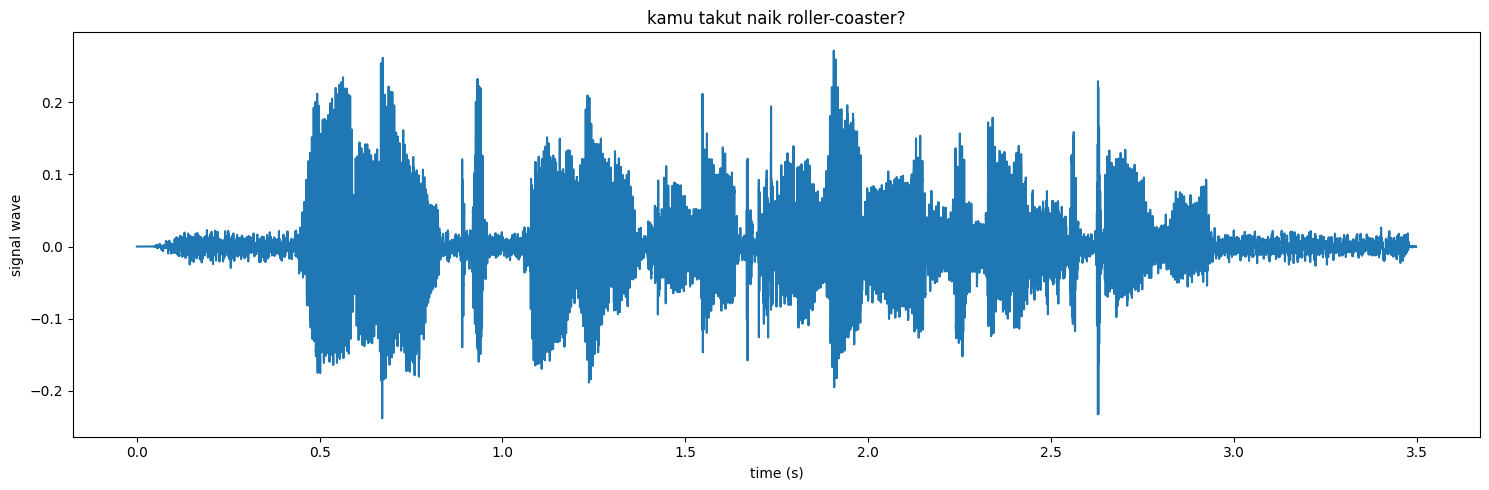

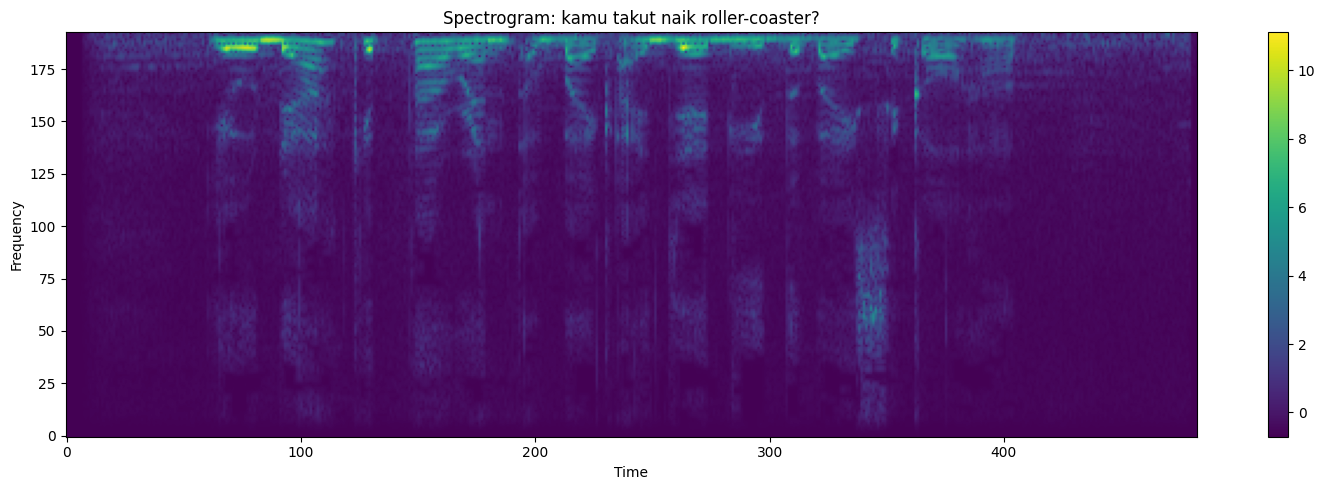

 27%|██▋       | 4/15 [00:03<00:09,  1.15it/s]

2
kamu takut naik rollercoaster?


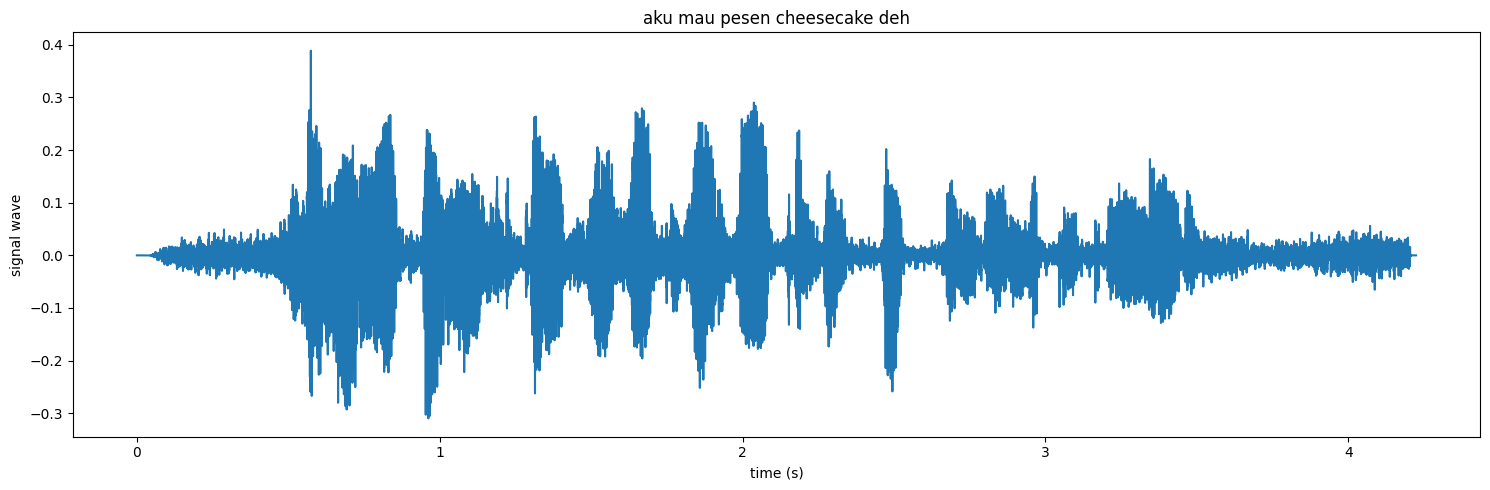

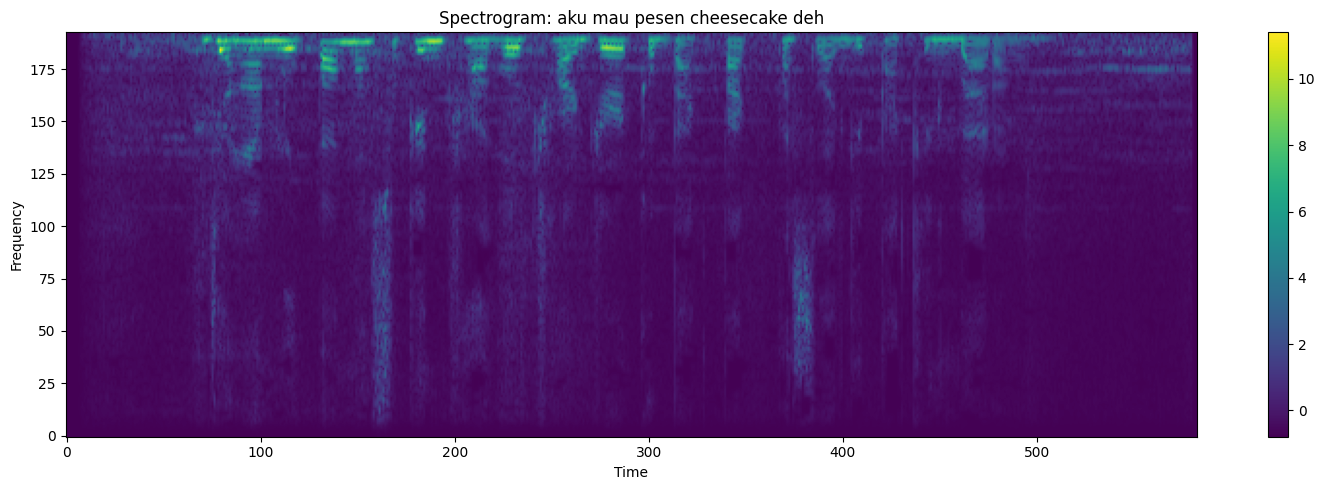

 33%|███▎      | 5/15 [00:04<00:08,  1.16it/s]

2
aku mau pesen cheesecake deh


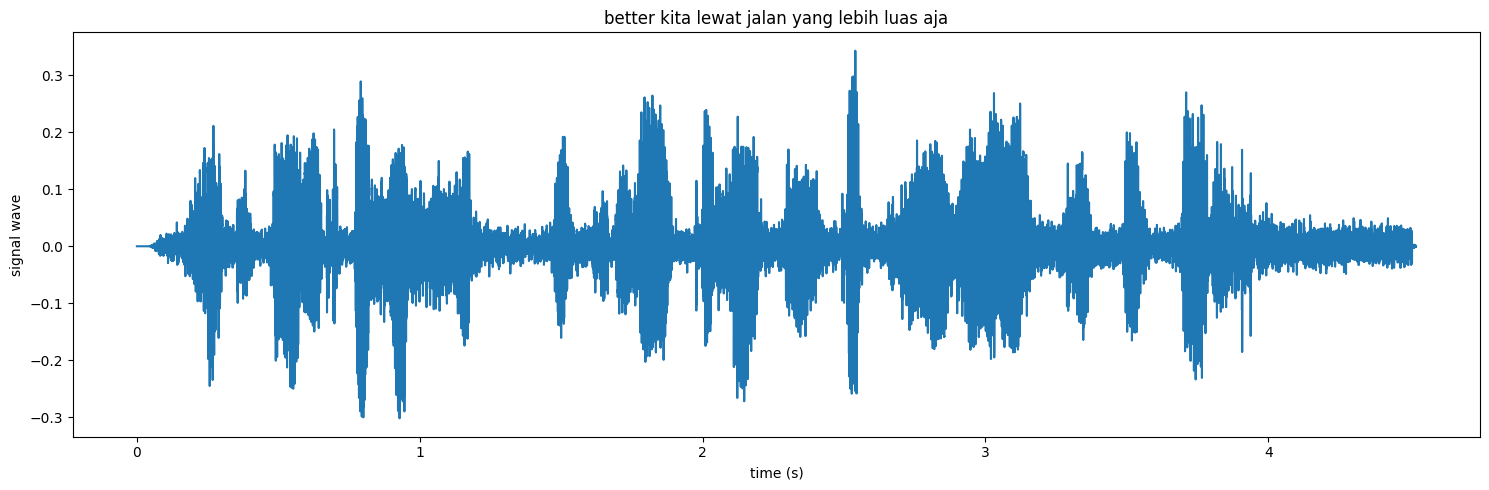

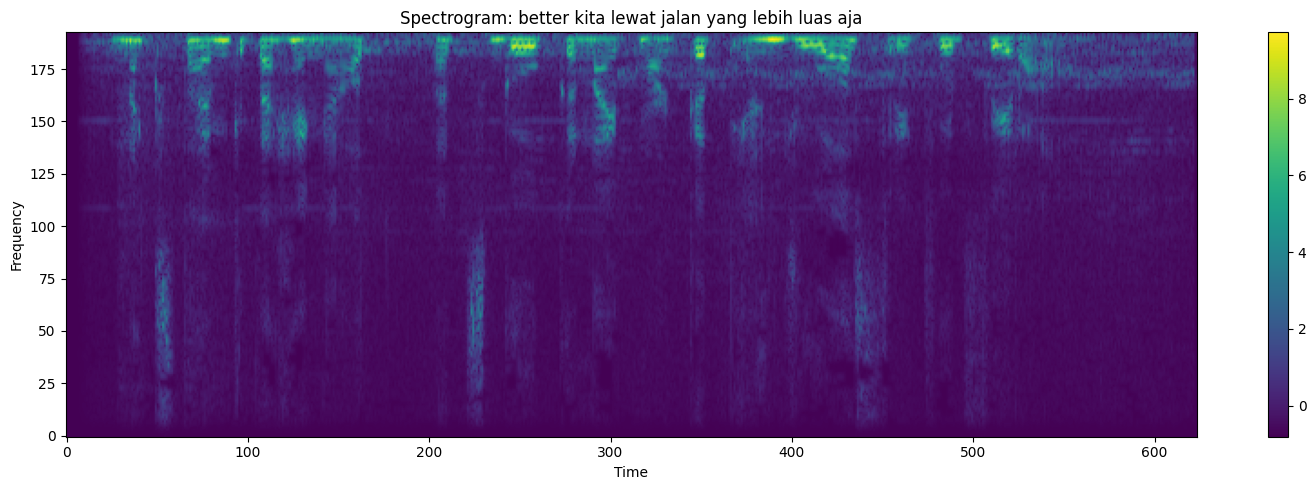

 40%|████      | 6/15 [00:05<00:08,  1.12it/s]

2
better kita lewat jalan yang lebih luas aja


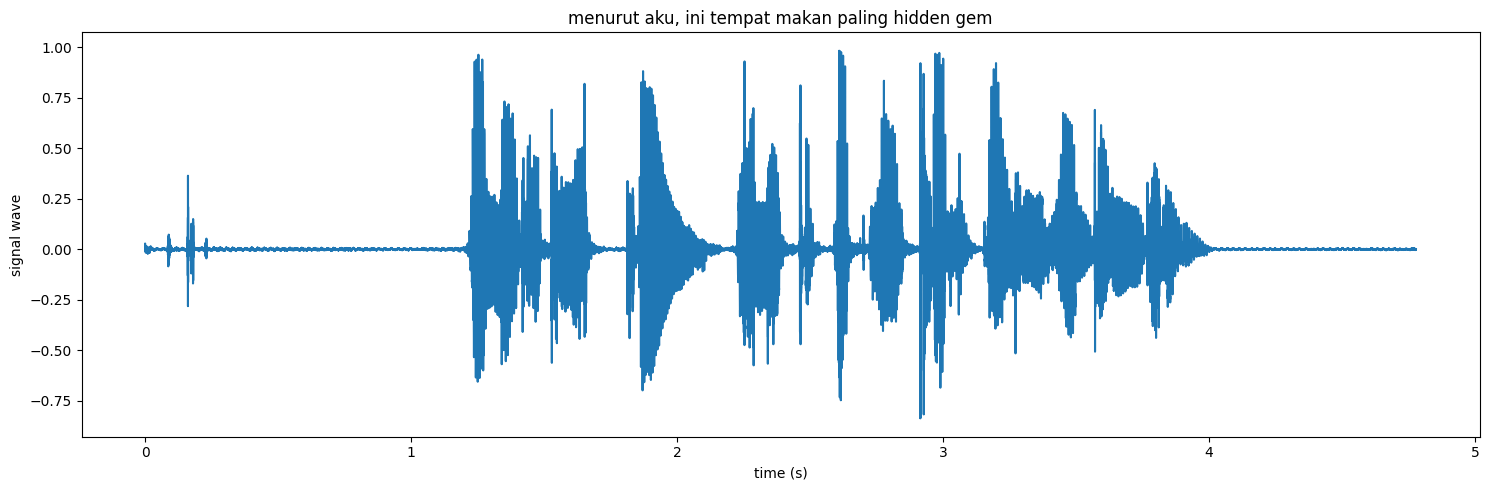

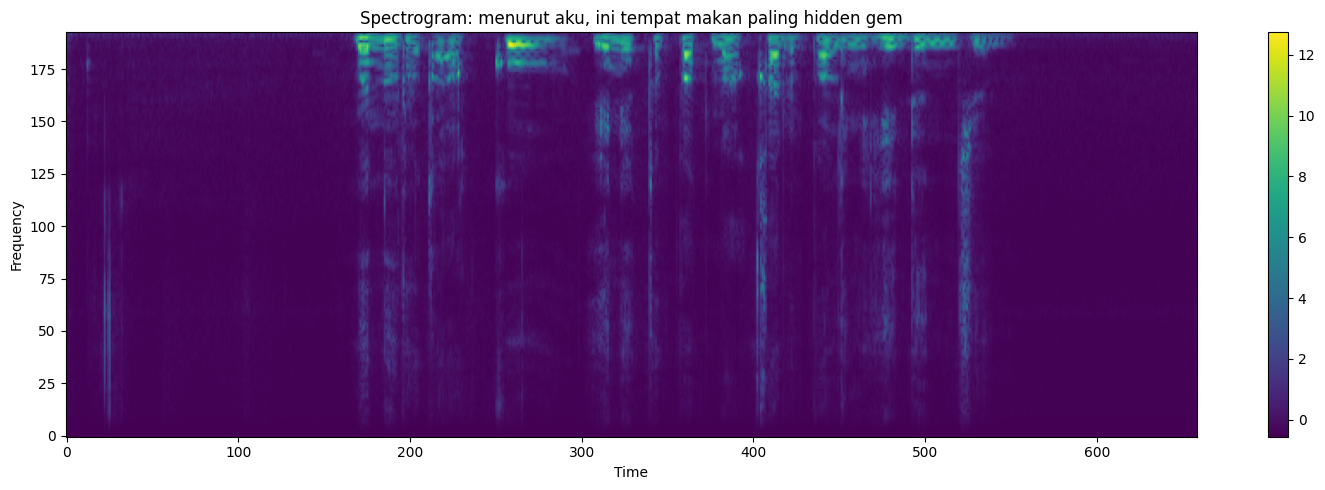

 47%|████▋     | 7/15 [00:06<00:06,  1.15it/s]

3
menurut aku ini tempat makan paling hidden gem


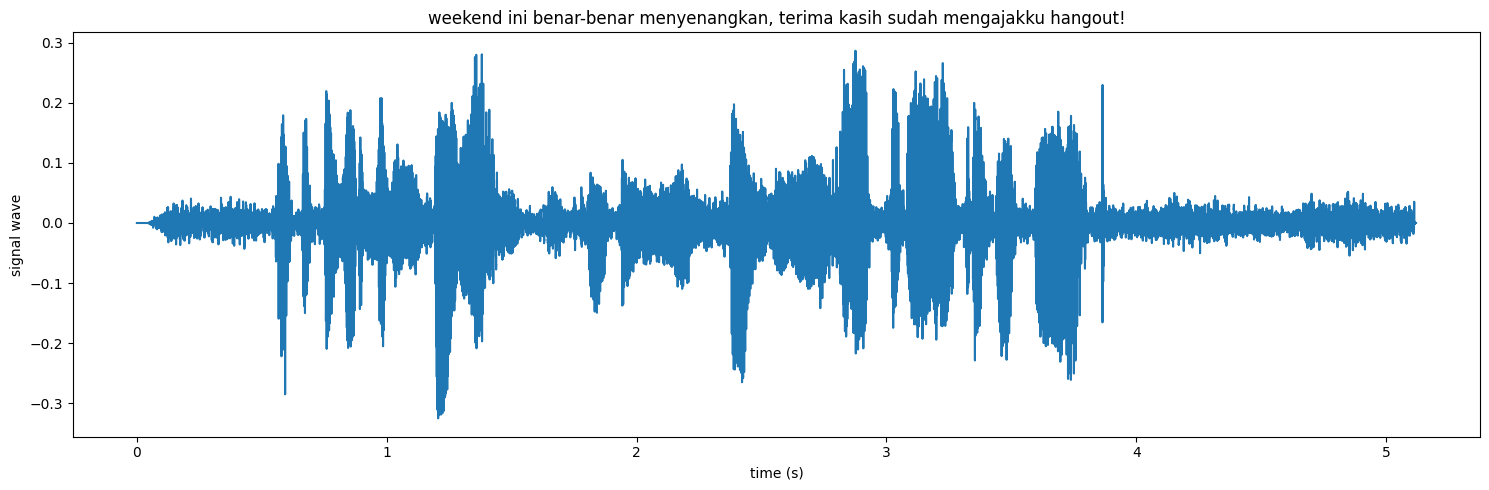

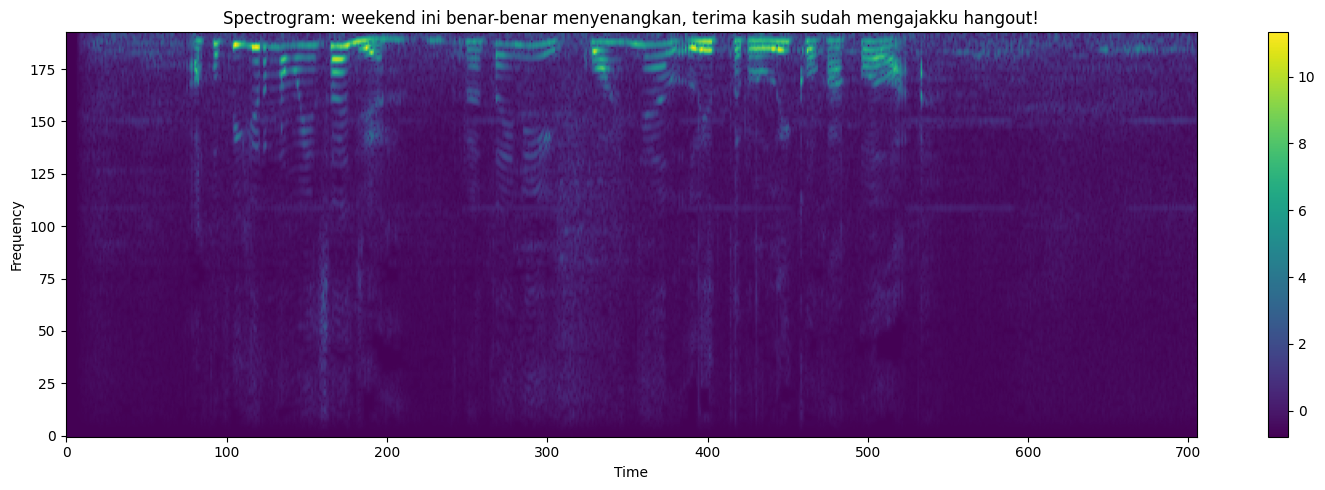

 53%|█████▎    | 8/15 [00:07<00:06,  1.14it/s]

2
weekend ini benarbenar menyenangkan terima kasih sudah mengajakku hangout!


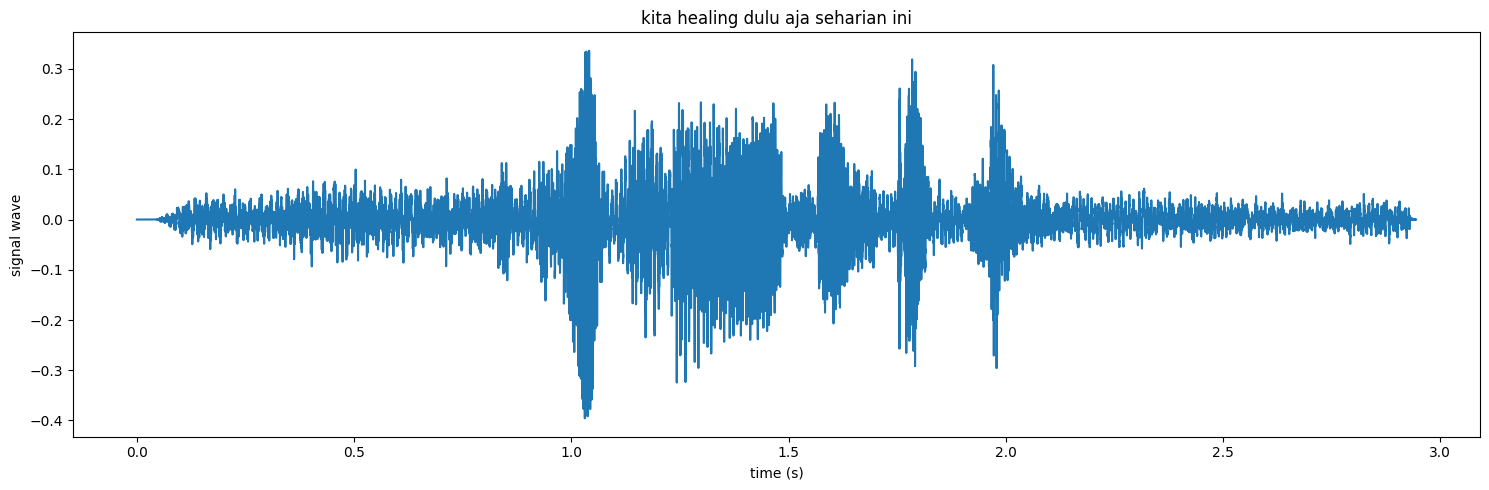

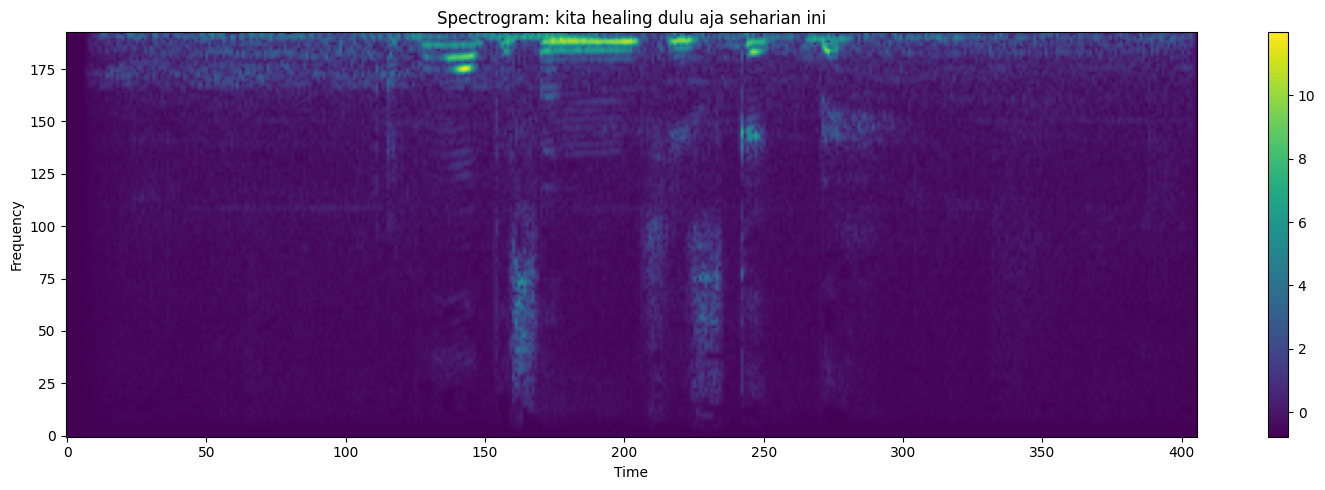

 60%|██████    | 9/15 [00:07<00:05,  1.14it/s]

2
kita healing dulu aja seharian ini


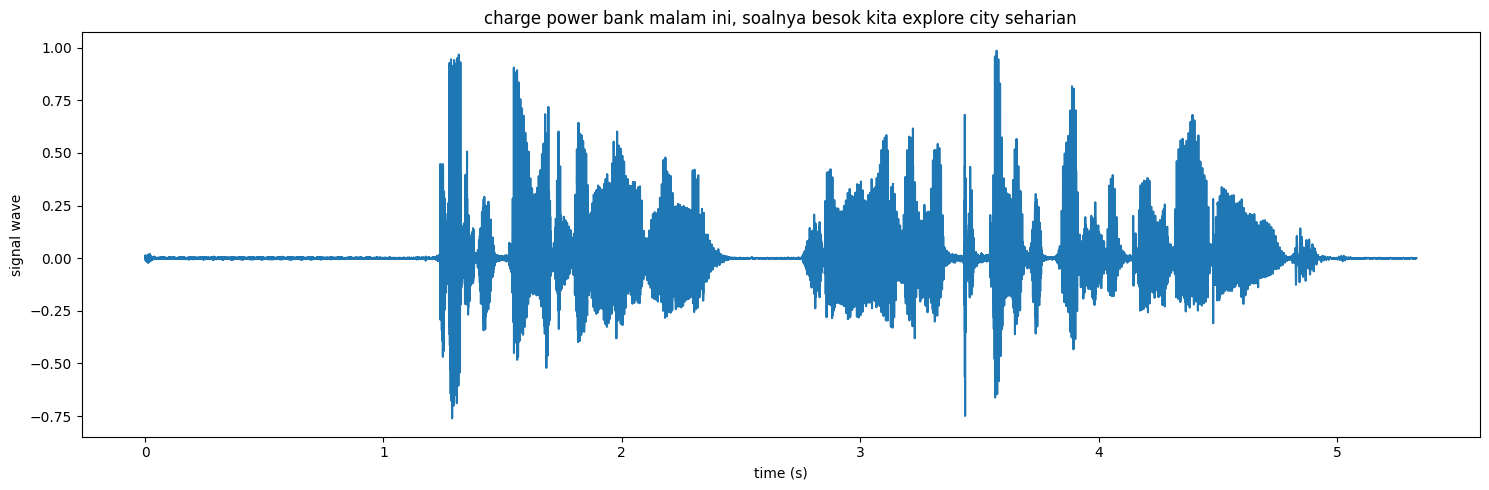

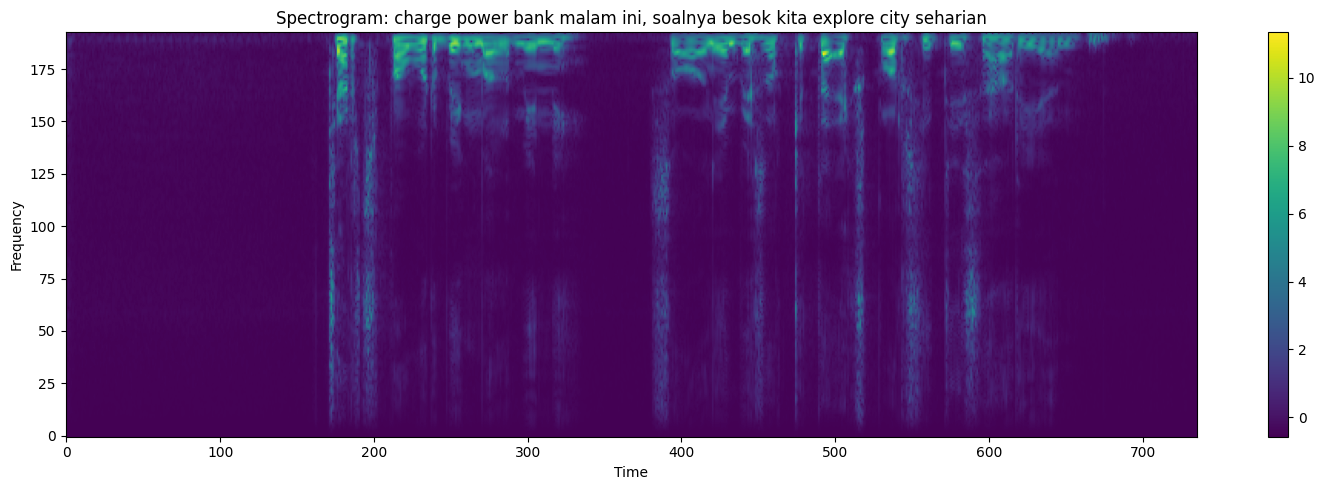

 67%|██████▋   | 10/15 [00:08<00:04,  1.16it/s]

3
charge power bank malam ini soalnya besok kita explore city seharian


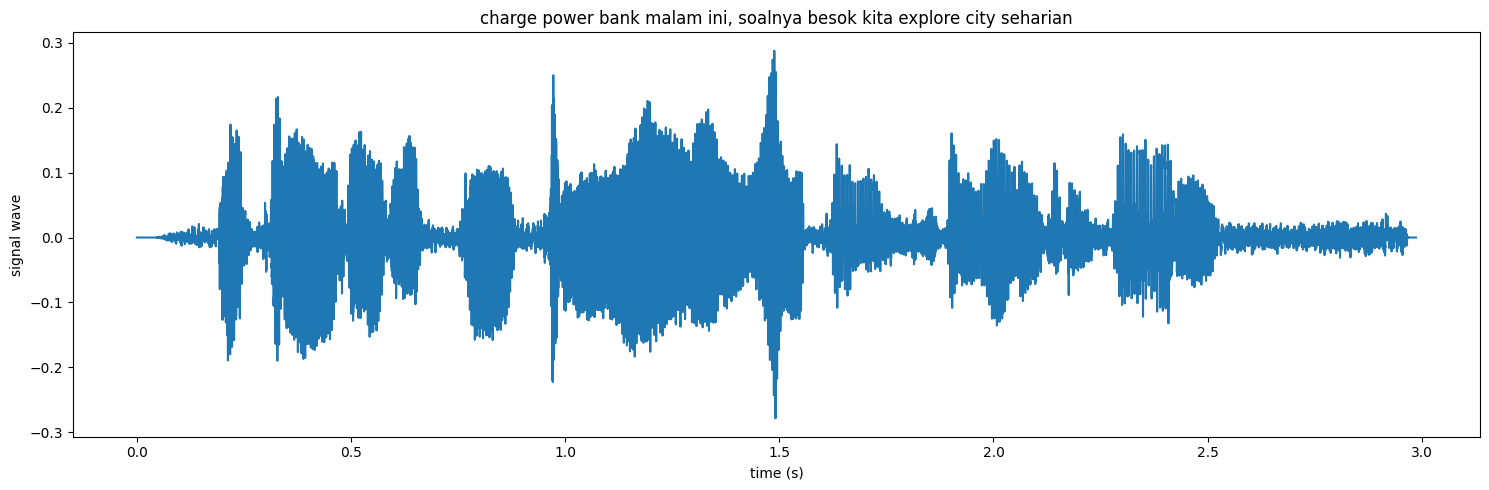

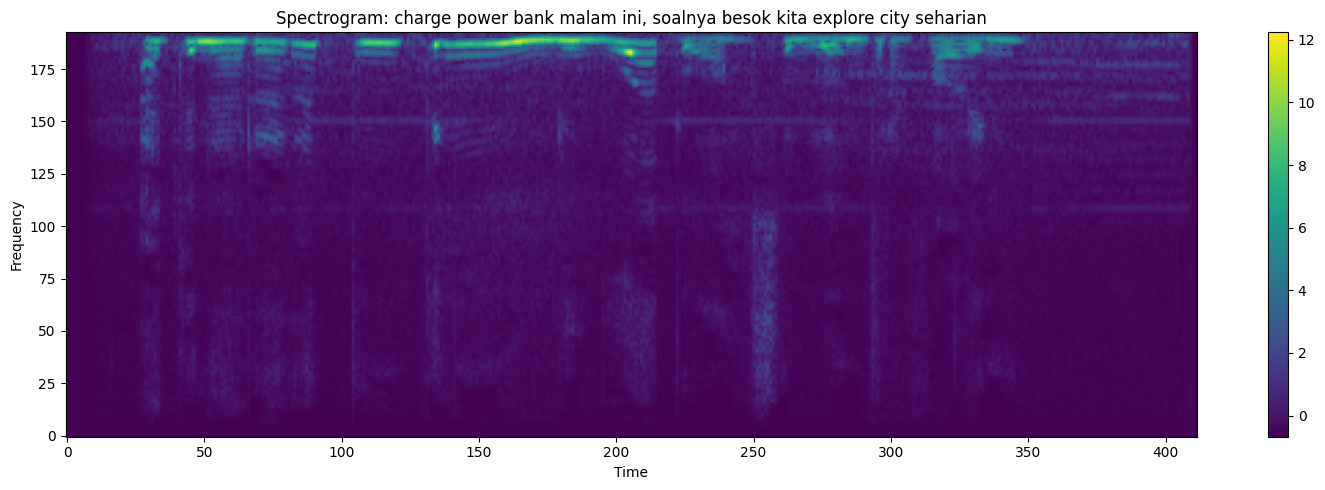

 73%|███████▎  | 11/15 [00:09<00:03,  1.14it/s]

3
charge power bank malam ini soalnya besok kita explore city seharian


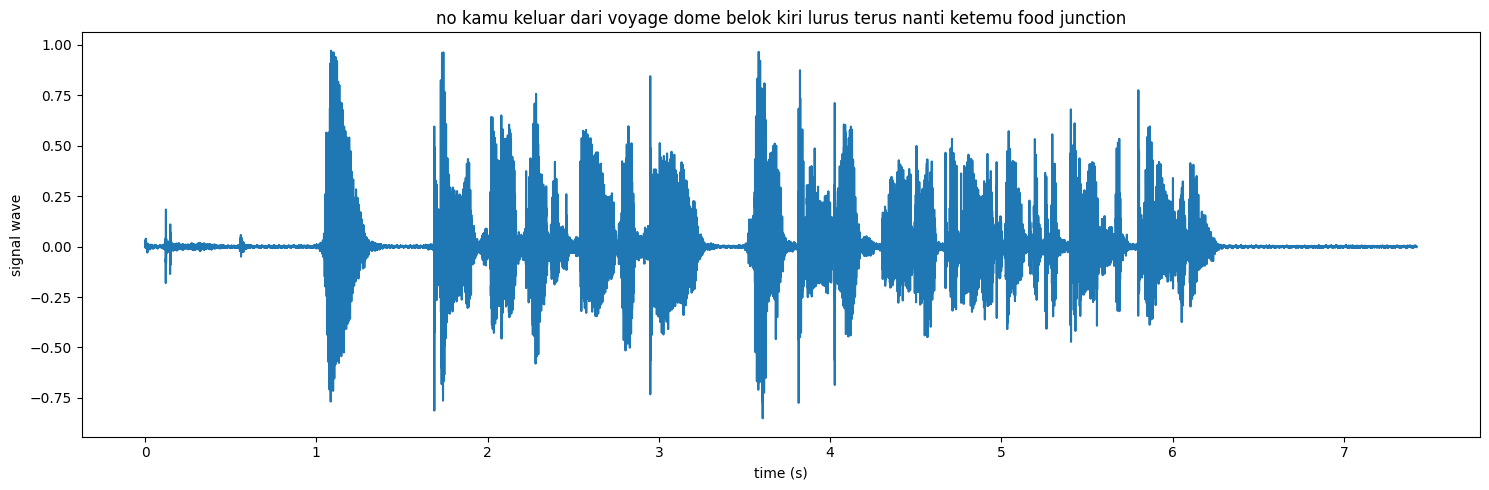

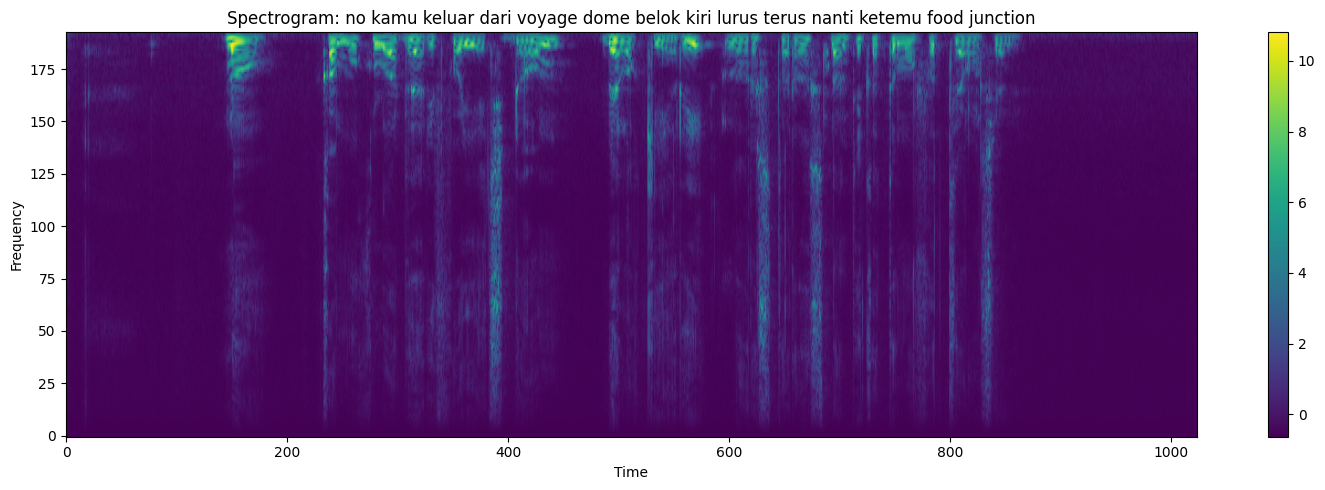

 80%|████████  | 12/15 [00:10<00:02,  1.10it/s]

3
no kamu keluar dari voyage dome belok kiri lurus terus nanti ketemu food junction


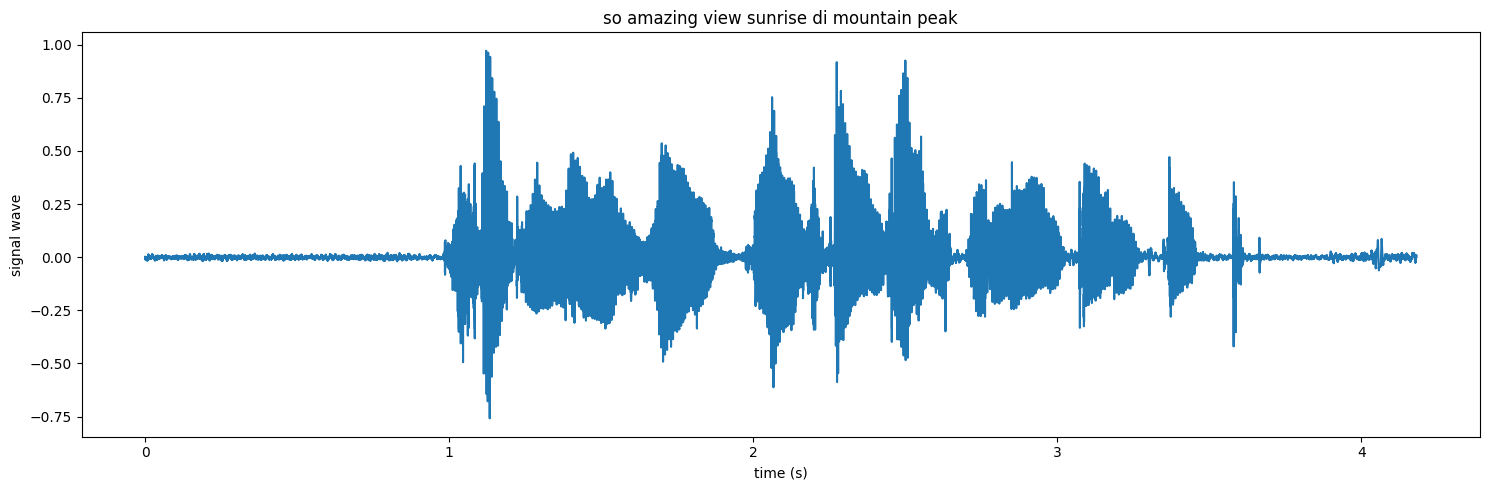

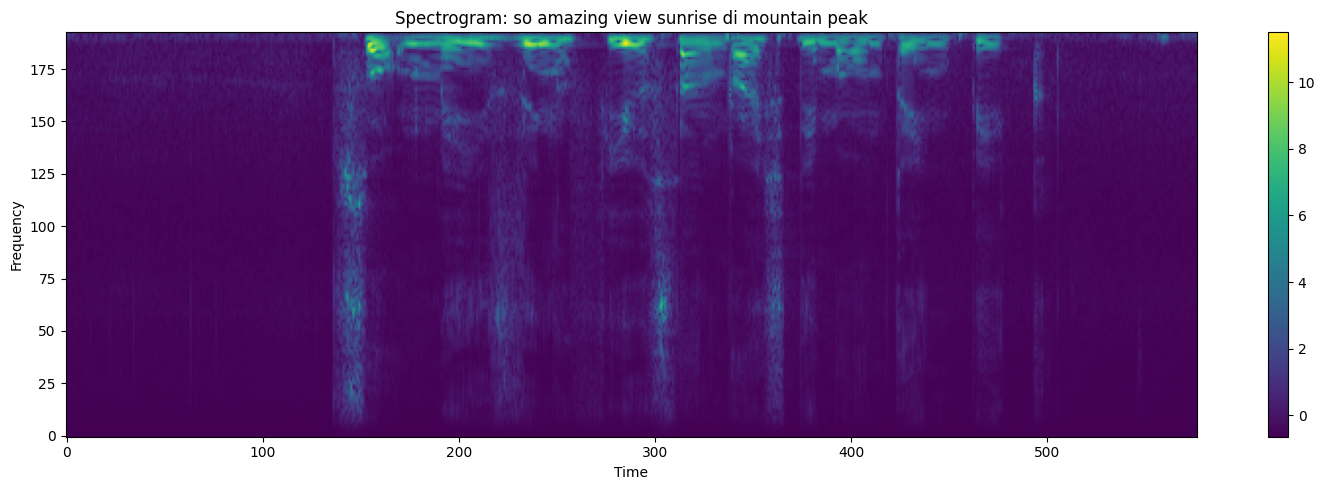

 87%|████████▋ | 13/15 [00:11<00:01,  1.10it/s]

2
so amazing view sunrise di mountain peak


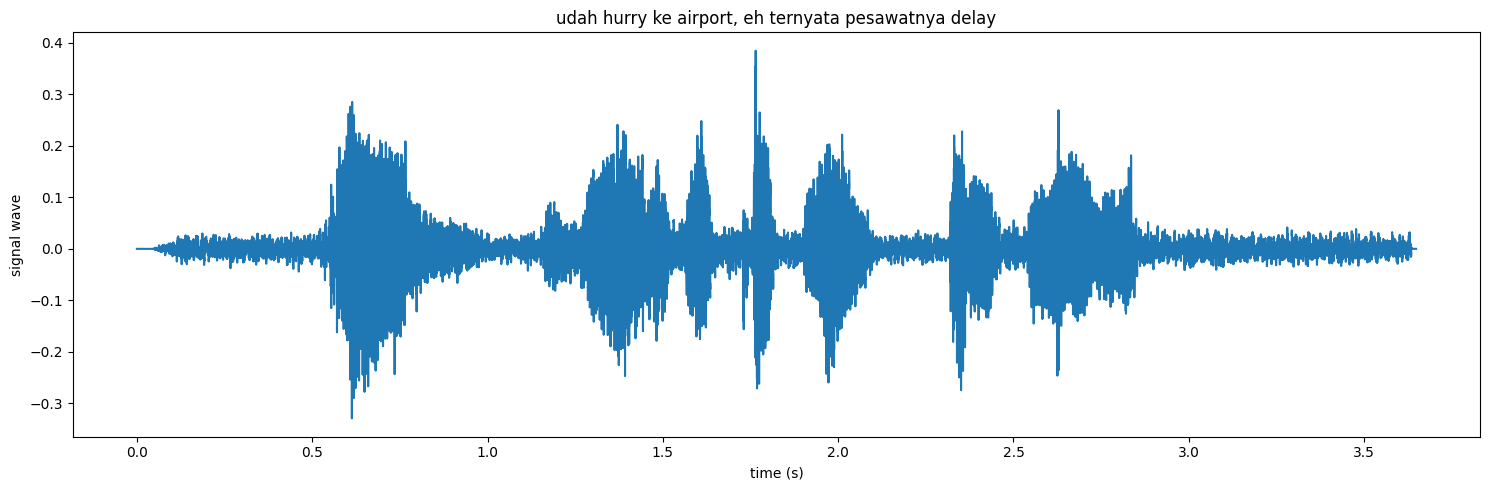

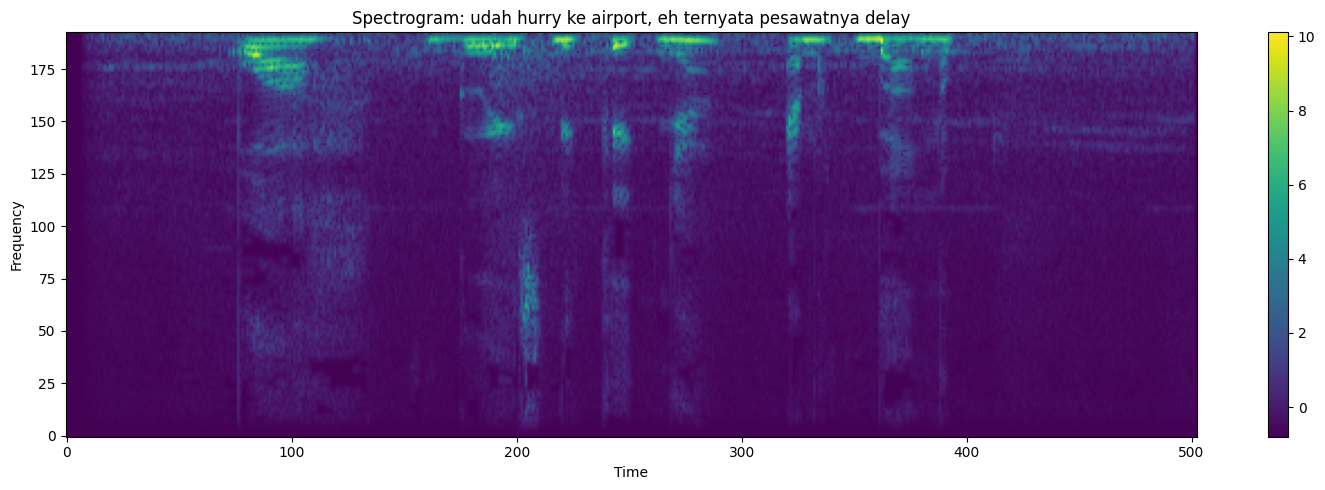

 93%|█████████▎| 14/15 [00:12<00:00,  1.09it/s]

2
udah hurry ke airport eh ternyata pesawatnya delay


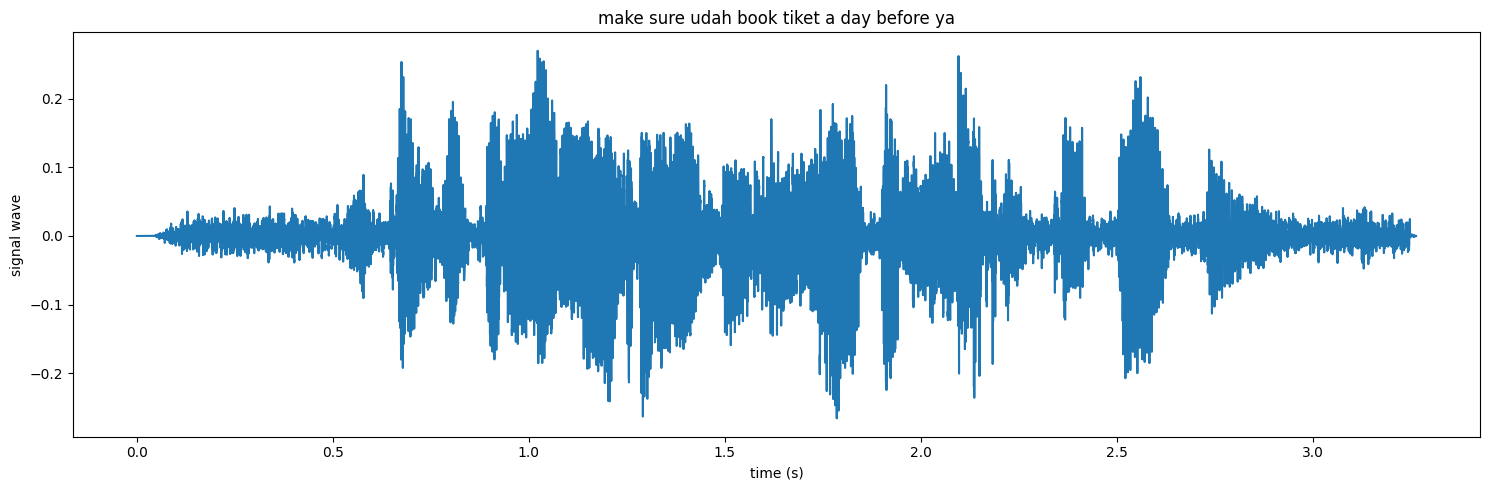

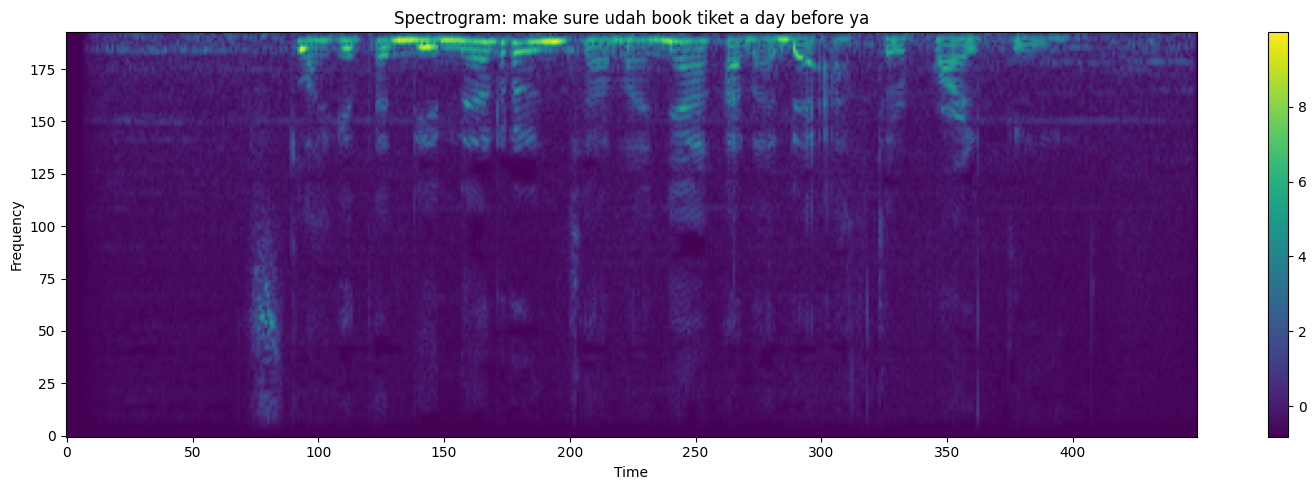

100%|██████████| 15/15 [00:13<00:00,  1.12it/s]

2
make sure udah book tiket a day before ya
Average CER: 0.9513780773729812, Average WER: 0.9925925925925926


In [24]:
# change path model
path_model = "Models/05_sound_to_text/202312021753/"
if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load(path_model+"configs.yaml")

    model = WavToTextModel(model_path=configs.model_path, char_list=configs.vocab, force_cpu=False)

    df = pd.read_csv(path_model+"val.csv").values.tolist()

    accum_cer, accum_wer = [], []
    for wav_path, label in tqdm(df):
        
        spectrogram = WavReader.get_spectrogram(wav_path, frame_length=configs.frame_length, frame_step=configs.frame_step, fft_length=configs.fft_length)
        WavReader.plot_raw_audio(wav_path, label)

        padded_spectrogram = np.pad(spectrogram, ((0, configs.max_spectrogram_length - spectrogram.shape[0]),(0,0)), mode="constant", constant_values=0)

        WavReader.plot_spectrogram(spectrogram, label)

        text = model.predict(padded_spectrogram)

        true_label = "".join([l for l in label.lower() if l in configs.vocab])

        cer = get_cer(text, true_label)
        wer = get_wer(text, true_label)
        print(len(text))
        print(true_label)

        accum_cer.append(cer)
        accum_wer.append(wer)

    print(f"Average CER: {np.average(accum_cer)}, Average WER: {np.average(accum_wer)}")

In [22]:
predicted_labels

array([[[0.02831023, 0.0317454 , 0.03013726, ..., 0.02904699,
         0.03111166, 0.04655776],
        [0.02823615, 0.03102499, 0.02984819, ..., 0.02856858,
         0.03135708, 0.04864943],
        [0.02808545, 0.03046703, 0.02958182, ..., 0.02815134,
         0.03161925, 0.05069448],
        ...,
        [0.02818313, 0.03104175, 0.03180069, ..., 0.02676016,
         0.03545513, 0.05060704],
        [0.02830383, 0.03110062, 0.03202556, ..., 0.02708598,
         0.03574417, 0.04768151],
        [0.02828211, 0.0310965 , 0.03231843, ..., 0.02727922,
         0.03605719, 0.04486547]]], dtype=float32)

In [18]:
predicted_labels.shape

(1, 327, 31)